In [ ]:
! pip install langchain langchain-chroma "unstructured[all-docs]" pydantic lxml

In [ ]:
from typing import Any
from pydantic import BaseModel
from unstructured.partition.pdf import partition_pdf

# Path to save images
path = "./figures/shortExample2/"

# Get elements
raw_pdf_elements = partition_pdf(
    filename='./data/shortExample2_Nutrition_20Pgs.pdf',
    # Using pdf format to find embedded image blocks
    extract_images_in_pdf=True,
    # Use layout model (YOLOX) to get bounding boxes (for tables) and find titles
    # Titles are any sub-section of the document
    infer_table_structure=True,
    # Post processing to aggregate text once we have the title
    chunking_strategy="by_title",
    # Chunking params to aggregate text blocks
    # Attempt to create a new chunk 3800 chars
    # Attempt to keep chunks > 2000 chars
    # Hard max on chunks
    max_characters=1000,
    new_after_n_chars=500,
    combine_text_under_n_chars=800,
    image_output_dir_path=path,
)

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [2]:
# Create a dictionary to store counts of each type
category_counts = {}

for element in raw_pdf_elements:
    category = str(type(element))
    if category in category_counts:
        category_counts[category] += 1
    else:
        category_counts[category] = 1

# Unique_categories will have unique elements
# TableChunk if Table > max chars set above
unique_categories = set(category_counts.keys())
category_counts

{"<class 'unstructured.documents.elements.CompositeElement'>": 77}

In [3]:
class Element(BaseModel):
    type: str
    text: Any


# Categorize by type
categorized_elements = []
for element in raw_pdf_elements:
    if "unstructured.documents.elements.Table" in str(type(element)):
        categorized_elements.append(Element(type="table", text=str(element)))
    elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
        categorized_elements.append(Element(type="text", text=str(element)))

# Tables
table_elements = [e for e in categorized_elements if e.type == "table"]
print(len(table_elements))

# Text
text_elements = [e for e in categorized_elements if e.type == "text"]
print(len(text_elements))

0
77


In [4]:
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

In [5]:
# Prompt
prompt_text = """You are an assistant tasked with summarizing tables and text. \
Give a concise summary of the table or text. Table or text chunk: {element} """
prompt = ChatPromptTemplate.from_template(prompt_text)

# Summary chain
model = ChatOllama(model="llama3.2")
summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

/var/folders/1y/_wk9p9f500d8xnl6kjnnkbp40000gn/T/ipykernel_68169/1508673027.py:7: LangChainDeprecationWarning: The class `ChatOllama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import ChatOllama``.
  model = ChatOllama(model="llama3.2")


In [6]:
# Apply to text
texts = [i.text for i in text_elements if i.text != ""]
text_summaries = summarize_chain.batch(texts, {"max_concurrency": 5})

In [7]:
# Apply to tables
tables = [i.text for i in table_elements]
table_summaries = summarize_chain.batch(tables, {"max_concurrency": 5})

In [8]:
print(text_summaries)
print(table_summaries)

["Here's a concise summary:\n\nCats have a less refined sense of taste compared to humans, with only 473 taste buds (compared to 9,000 in humans). Their sense of taste is limited to basic flavors like sour, bitter, and salty, as they are strictly carnivorous and don't need to detect sweet tastes.", 'Here is a concise summary:\n\nCats use their unique tongues for grooming and catching prey, with tiny hook-like barbs that help remove feathers and fur. They also have a superior sense of smell, which compensates for their poor taste sense.', "Here's a concise summary:\n\nCats are obligate carnivores requiring a high-protein diet (at least 26%) and moderate fat intake to thrive. Their natural diet consists of meat, which provides 40% protein, 50% fat, and only 3% carbohydrates. Cats have unique adaptations that allow them to metabolize protein and fat efficiently, making it essential to avoid feeding dog food or low-protein diets, as they can lead to nutrient deficiencies.", 'Here is a conc

# Image Summary Generatetion
From the LangChain Cookbook, they used a LLaVA 7B model to generate image summaries in .txt. Those files will be in the same dir as those images. However, I have llama3.2-vision already installed and setup on my local machine. 

Llama3.2-vision model is a 11B model which may require a strong computing power and large memory. Switch model if necessary. i.e. Llava, Qwen, Gemma, etc.

# ⚠️Patch:
Generic query often won't trigger the LLM to include image in the response. AI analysis shows it could be a problem of how images summaries were created. Retriever performs sematic matching to retrieve relevant chunks, but the current summaries was written in a outsider perspective. It'd be better to try following prompt in making summaries.

'content': 'Describe the image in detail, focusing on any actions, techniques, or procedures depicted related to pet handling or care. Explain the purpose or context of the actions shown, if clear. Be concise and relevant to veterinary advice.'

# ✅ Side Note:
There are many irrelevant images exist in the textbook, like paragraph divider, section dividers, etc. In future development, consider using a **Node/Agent** to decide if a image should be filtered out for summarization.


In [12]:
import ollama
import os
import base64

# Directories
image_directory = "./figures/shortExample2/"
output_directory = "./figures/shortExample2/"

# Ensure output directory exists
os.makedirs(output_directory, exist_ok=True)

# Supported image formats
supported_extensions = ('.png', '.jpg', '.jpeg')

for filename in os.listdir(image_directory):
    if filename.lower().endswith(supported_extensions):
        image_path = os.path.join(image_directory, filename)
        output_filename = os.path.splitext(filename)[0] + ".txt"
        output_path = os.path.join(output_directory, output_filename)

        print(f"⏳ Working on summary for {filename}")

        # Check if the summary file already exists
        if os.path.exists(output_path):
            print(f"☑️ Summary for {filename} already exists at {output_path}, skipping.")
            continue

        try:
            # Read and encode image in base64
            with open(image_path, 'rb') as f:
                image_data = base64.b64encode(f.read()).decode('utf-8')

            # Send image to ollama for vision model processing
            response = ollama.chat(
                model='llava:7b',
                messages=[
                    {
                        'role': 'user',
                        'content': 'Describe the image in detail, focusing on any actions, techniques, or procedures depicted related to pet handling or care. Explain the purpose or context of the actions shown, if clear. Be concise and relevant to veterinary advice. If you think the images has nothing to do with veterinary, do not do anything.',  
                        'images': [image_data]
                    }
                ]
            )

            # Extract and save the generated summary
            summary = response['message']['content']
            
            with open(output_path, 'w') as f:
                f.write(summary)

            print(f"✅ Summary for {filename} saved to {output_path}")

        except Exception as e:
            print(f"❌ Error processing {filename}: {e}") 

⏳ Working on summary for figure-8-6.jpg
✅ Summary for figure-8-6.jpg saved to ./figures/shortExample2/figure-8-6.txt
⏳ Working on summary for figure-20-20.jpg
✅ Summary for figure-20-20.jpg saved to ./figures/shortExample2/figure-20-20.txt
⏳ Working on summary for figure-13-11.jpg
✅ Summary for figure-13-11.jpg saved to ./figures/shortExample2/figure-13-11.txt
⏳ Working on summary for figure-15-14.jpg
✅ Summary for figure-15-14.jpg saved to ./figures/shortExample2/figure-15-14.txt
⏳ Working on summary for figure-9-7.jpg
✅ Summary for figure-9-7.jpg saved to ./figures/shortExample2/figure-9-7.txt
⏳ Working on summary for figure-17-16.jpg
✅ Summary for figure-17-16.jpg saved to ./figures/shortExample2/figure-17-16.txt
⏳ Working on summary for figure-5-3.jpg
✅ Summary for figure-5-3.jpg saved to ./figures/shortExample2/figure-5-3.txt
⏳ Working on summary for figure-19-18.jpg
✅ Summary for figure-19-18.jpg saved to ./figures/shortExample2/figure-19-18.txt
⏳ Working on summary for figure-7-

# Read image and summaries from folder

In [23]:
import glob
import os

path =  "./figures/shortExample2/"
# Get all .txt files in the directory
file_paths = glob.glob(os.path.expanduser(os.path.join(path, "*.txt")))

# Supported image formats
supported_extensions = ('.png', '.jpg', '.jpeg')

# Read each file and store its content in a list, and collect corresponding image paths
img_summaries = []
image_paths = []
for file_path in file_paths:
    with open(file_path, "r") as file:
        img_summaries.append(file.read())
    
    # Derive the original image path from the summary file path
    base_filename = os.path.splitext(os.path.basename(file_path))[0]
    found_image_path = None
    for ext in supported_extensions:
        potential_image_path = os.path.join(path, base_filename + ext)
        if os.path.exists(potential_image_path):
            found_image_path = potential_image_path
            break
    image_paths.append(found_image_path)

# Clean up residual logging
# cleaned_img_summary = [
#     s.split("clip_model_load: total allocated memory: 201.27 MB\\n\\n", 1)[1].strip() #Llava Model could left this message at every summary. This line is here to remove the overhead.
#     for s in img_summaries
# ]

# Filter out entries where no corresponding image was found
# This ensures cleaned_img_summary and image_paths remain aligned
# filtered_img_summaries = []
# filtered_image_paths = []
# for i, summary in enumerate(cleaned_img_summary):
#     if image_paths[i] is not None:
#         filtered_img_summaries.append(summary)
#         filtered_image_paths.append(image_paths[i])

cleaned_img_summary = img_summaries
image_paths

['./figures/figure-4-9.jpg',
 './figures/figure-4-8.jpg',
 './figures/figure-2-5.jpg',
 './figures/figure-5-10.jpg',
 './figures/figure-2-4.jpg',
 './figures/figure-2-3.jpg',
 './figures/figure-4-7.jpg',
 './figures/figure-3-6.jpg',
 './figures/figure-1-2.jpg',
 './figures/figure-1-1.jpg']

# Now, storing all those in a vector DB.


In [36]:
import uuid

from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryStore
from langchain_chroma import Chroma
from langchain_community.embeddings import GPT4AllEmbeddings
from langchain_core.documents import Document

# The vectorstore to use to index the child chunks
vectorstore = Chroma(
    collection_name="summaries", embedding_function=GPT4AllEmbeddings()
)

# The storage layer for the parent documents
store = InMemoryStore()  # <- Can we extend this to images
id_key = "doc_id"

# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
)


In [35]:
# Ensure you have initialized your vectorstore variable (e.g., by running previous cells)
# This will delete the Chroma collection named "summaries"
vectorstore.delete_collection()
print("Chroma collection 'summaries' has been deleted.")

Chroma collection 'summaries' has been deleted.


In [37]:
# Add texts
if texts:
    doc_ids = [str(uuid.uuid4()) for _ in texts]
    summary_texts = [
        Document(page_content=s, metadata={id_key: doc_ids[i]})
        for i, s in enumerate(text_summaries)
    ]
    retriever.vectorstore.add_documents(summary_texts)
    retriever.docstore.mset(list(zip(doc_ids, texts)))


# Add tables
if tables:
    table_ids = [str(uuid.uuid4()) for _ in tables]
    summary_tables = [
        Document(page_content=s, metadata={id_key: table_ids[i]})
        for i, s in enumerate(table_summaries)
    ]
    retriever.vectorstore.add_documents(summary_tables)
    retriever.docstore.mset(list(zip(table_ids, tables)))

    # Add images
# Add images
if cleaned_img_summary:
    img_ids = [str(uuid.uuid4()) for _ in cleaned_img_summary]
    summary_img = [
        Document(page_content=s, metadata={id_key: img_ids[i]})
        for i, s in enumerate(cleaned_img_summary)
    ]
    retriever.vectorstore.add_documents(summary_img)
    # Store the image path as the raw document for retrieval
    retriever.docstore.mset(
        list(zip(img_ids, image_paths))
    )
 # Store the image summary as the raw document

In [38]:
try_result = retriever.invoke("Images / figures with cat in a white background")
try_result

['./figures/figure-4-8.jpg',
 './figures/figure-2-4.jpg',
 './figures/figure-1-1.jpg',
 './figures/figure-3-6.jpg']

In [72]:
import io
import re

from IPython.display import HTML, display
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from langchain_core.messages import HumanMessage
from PIL import Image

def plt_img_base64(img_base64):
    """Disply base64 encoded string as image"""
    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'
    # Display the image by rendering the HTML
    display(HTML(image_html))

def looks_like_base64(sb):
    """Check if the string looks like base64"""
    return re.match("^[A-Za-z0-9+/]+[=]{0,2}$", sb) is not None



def split_image_text_types(docs):
    """
    Split base64-encoded images and texts from a list of documents/strings.
    Handles both Document objects and direct image path strings.
    Only the first identified image will be base64 encoded and marked for Markdown rendering.
    Subsequent image paths will be added as plain text references.
    """
    b64_images = []
    texts = []
    image_processed = False # Flag to ensure only one image is processed visually

    for doc in docs:
        # Determine the content based on whether 'doc' is a Document object or a string
        doc_content = doc.page_content if isinstance(doc, Document) else str(doc)

        # Check if the content is an image path and if the file exists
        if doc_content.lower().endswith(('.png', '.jpg', '.jpeg')) and os.path.exists(doc_content):
            if not image_processed: # Process only the first image visually
                image_path = doc_content
                try:
                    with open(image_path, 'rb') as f:
                        image_data = base64.b64encode(f.read()).decode('utf-8')
                        resized_image_data = resize_base64_image(image_data, size=(1300, 600))
                        b64_images.append(resized_image_data)
                    # Add the image path for Markdown rendering in the LLM response
                    texts.append(f"IMAGE_PATH_FOR_MD: {image_path}")
                    image_processed = True # Set flag to true after processing the first image
                except Exception as e:
                    print(f"Error loading image {image_path}: {e}")
                    texts.append(doc_content) # If error, treat as text
            else:
                # For subsequent image paths, just add a textual reference without the special tag
                texts.append(f"An additional image related to the context was found at: {os.path.basename(doc_content)}")
        else:
            # It's text or a table summary
            texts.append(doc_content)
    return {"images": b64_images, "texts": texts}


def img_prompt_func(data_dict):
    """
    Construct the messages for the multimodal LLM.
    `data_dict` will contain keys: 'context' (which is {'images': [...], 'texts': [...]}) and 'question'.
    Instructs the LLM to render ALL image paths found via Markdown, striving to include images where relevant.
    """
    formatted_texts = "\n".join(data_dict["context"]["texts"])
    messages = []

    # Debugging: Print images being passed to the model
    print(f"DEBUG: Images being passed to LLM (visually): {len(data_dict['context']['images'])} image(s)")
    if data_dict["context"]["images"]:
        print(f"DEBUG: First visual image (base64 snippet): {data_dict['context']['images'][0][:50]}...")

    # Adding image(s) to the messages if present (this is the visual input)
    if data_dict["context"]["images"]:
        for image in data_dict["context"]["images"]:
            image_message = {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{image}"},
            }
            messages.append(image_message)

    # Adding the text for analysis, with stronger instructions for Markdown rendering
    text_message = {
        "type": "text",
        "text": (
            "You are a veterinary assistant tasked with providing veterinary advice. "
            "You will be given a mixed of text, tables, and image references. "
            "Your primary goal is to use all provided information, including images, to answer the user's question comprehensively. "
            "It is ESSENTIAL that you identify ALL instances of `IMAGE_PATH_FOR_MD: /path/to/image.jpg` in the context "
            "and convert them directly into Markdown image syntax within your response. "
            "For each image, provide a brief, accurate alt text description like `![Description of image content](/path/to/image.jpg)`. "
            "For example, if the context contains `IMAGE_PATH_FOR_MD: ./figures/cat_pickup.jpg`, you MUST output `![Illustration of cat pickup technique](./figures/cat_pickup.jpg)`. "
            "Include these Markdown images strategically where they best illustrate your points in the answer. "
            "Do NOT omit any `IMAGE_PATH_FOR_MD:` entries; they must be rendered as Markdown images. "
            f"User-provided question: {data_dict['question']}\n\n"
            "Text and / or tables:\n"
            f"{formatted_texts}"
        ),
    }
    messages.append(text_message)
    return [HumanMessage(content=messages)]

def is_image_data(b64data):
    """
    Check if the base64 data is an image by looking at the start of the data
    """
    image_signatures = {
        b"\xff\xd8\xff": "jpg",
        b"\x89\x50\x4e\x47\x0d\x0a\x1a\x0a": "png",
        b"\x47\x49\x46\x38": "gif",
        b"\x52\x49\x46\x46": "webp",
    }
    try:
        header = base64.b64decode(b64data)[:8]  # Decode and get the first 8 bytes
        for sig, format in image_signatures.items():
            if header.startswith(sig):
                return True
        return False
    except Exception:
        return False


def resize_base64_image(base64_string, size=(128, 128)):
    """
    Resize an image encoded as a Base64 string
    """
    # Decode the Base64 string
    img_data = base64.b64decode(base64_string)
    img = Image.open(io.BytesIO(img_data))

    # Resize the image
    resized_img = img.resize(size, Image.LANCZOS)

    # Save the resized image to a bytes buffer
    buffered = io.BytesIO()
    resized_img.save(buffered, format=img.format)

    # Encode the resized image to Base64
    return base64.b64encode(buffered.getvalue()).decode("utf-8")


def multi_modal_rag_chain(retriever):
    """
    Multi-modal RAG chain
    """

    # Multi-modal LLM
    model = ChatOllama(model="llama3.2-vision")

    # RAG pipeline
    chain = (
        {
            "context": retriever | RunnableLambda(split_image_text_types),
            "question": RunnablePassthrough(),
        }
        | RunnableLambda(img_prompt_func) # This consumes the {"context": {"images": ..., "texts": ...}, "question": ...} dict
        | model
        | StrOutputParser()
    )

    return chain

# Create RAG chain
# Assuming 'retriever' is already defined from previous cells
chain_multimodal_rag = multi_modal_rag_chain(retriever)

In [63]:
# Check retrieval
query = "what would be the best way to pick up a cat?"
docs = retriever.invoke(query, limit=8)

# We get 4 docs
len(docs)

4

Retrieved 4 documents:

--- Document 1 ---
Text Content:
PICKING UP A CAT

As a general rule, it is advisable to reach down and pick up a cat from above. A face-to-face confrontation might provoke the cat into becoming uncooper- ative or aggressive.

Cooperative cats can be picked up by placing one hand around the cat beneath the chest and taking hold of the cat’s front legs so they cross over each other, keeping your index finger between them for a secure grip. Pick up the cat and snuggle him close to your body, supporting his hind legs if neces- sary. Cradle his chin with your other hand.

To pick up an apprehensive cat, reach down and grasp him by the scruff of the neck.

Secure the back feet with your other hand.

—o—

04_095300 ch01.qxp 10/29/07 3:41 PM Page 3

2h

--- Document 2 ---
Text Content:
fh 7

04_095300 ch01.qxp 10/29/07 3:41 PM Page 4

4 • CAT OWNER’S HOME VETERINARY HANDBOOK

Frightened cats can be picked up by covering the animal with a towel. After a minute or two, a


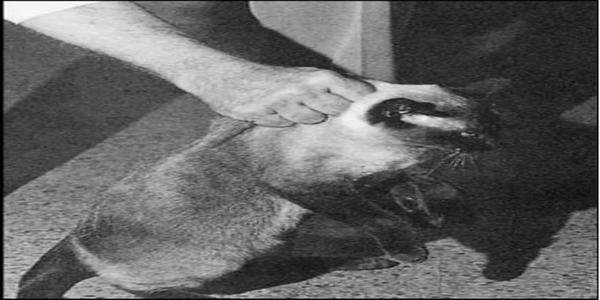

Displayed image from: ./figures/figure-1-1.jpg

--- Document 4 ---



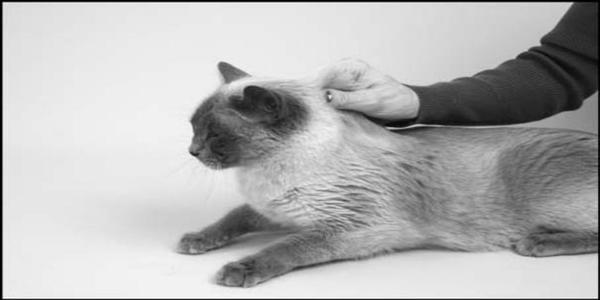

Displayed image from: ./figures/figure-3-6.jpg

--- LLM Response ---
DEBUG: Images being passed to LLM (visually): 1 image(s)
DEBUG: First visual image (base64 snippet): /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQ...
**Picking Up a Cat: A Step-by-Step Guide**

**General Rule:**
When picking up a cat, it's best to approach from above to avoid face-to-face confrontation, which can lead to uncooperation or aggression.

**Picking Up a Cooperative Cat:**

1. Place one hand around the cat beneath the chest.
2. Take hold of the cat's front legs, ensuring they cross over each other, with your index finger between them for a secure grip.
3. Pick up the cat and snuggle it close to your body, supporting its hind legs if necessary.
4. Cradle the cat's chin with your other hand.

**Picking Up an Apprehensive Cat:**

1. Reach down and grasp the cat by the scruff of the neck.
2. Secure the back feet with your other hand.

**Picking Up a Frightened or Aggressive Cat:**

1. Cover the cat with a 

In [77]:
# Your query
query = "Can you show me how to pick up a cat? Include images"

# Retrieve documents
docs = retriever.invoke(query, limit=6)

print(f"Retrieved {len(docs)} documents:")

# Iterate and display each document
for i, doc in enumerate(docs):
    doc_content = doc.page_content if isinstance(doc, Document) else str(doc)

    print(f"\n--- Document {i+1} ---")
    if doc_content.lower().endswith(('.png', '.jpg', '.jpeg')) and os.path.exists(doc_content):
        # It's an image path
        image_path = doc_content
        try:
            with open(image_path, 'rb') as f:
                image_data = base64.b64encode(f.read()).decode('utf-8')
                # Resize for display if needed, using your existing function
                # You might want to use a smaller size here for better display in notebook
                resized_image_data = resize_base64_image(image_data, size=(600, 300))
                plt_img_base64(resized_image_data)
                print(f"Displayed image from: {image_path}")
        except Exception as e:
            print(f"Error reading or displaying image {image_path}: {e}")
    else:
        # It's text or a table summary
        print(f"Text Content:\n{doc_content}")

print("\n--- LLM Response ---")
# Finally, get the LLM's answer using the chain
llm_response = chain_multimodal_rag.invoke(query)
print(llm_response)


In [78]:
from IPython.display import Markdown

# Assuming llm_response contains the string output from your chain
# llm_response = chain_multimodal_rag.invoke(query) # Run this to get the response
display(Markdown(llm_response))

**Picking Up a Cat: A Step-by-Step Guide**

**General Rule:**
When picking up a cat, it's best to approach from above to avoid face-to-face confrontation, which can lead to uncooperation or aggression.

**Picking Up a Cooperative Cat:**

1. Place one hand around the cat beneath the chest.
2. Take hold of the cat's front legs, ensuring they cross over each other, with your index finger between them for a secure grip.
3. Pick up the cat and snuggle it close to your body, supporting its hind legs if necessary.
4. Cradle the cat's chin with your other hand.

**Picking Up an Apprehensive Cat:**

1. Reach down and grasp the cat by the scruff of the neck.
2. Secure the back feet with your other hand.

**Picking Up a Frightened or Aggressive Cat:**

1. Cover the cat with a towel.
2. After a minute or two, as the cat becomes calmer, slide the rest of the towel underneath and lift the cat up as a bundle.
3. Consider wearing thick leather gloves and using a thick blanket for added safety.
4. Push a slip leash over the cat's head to prevent escape.

**Additional Image:**
![A cat being picked up by a person, with the cat's front legs crossing over each other](./figures/figure-1-1.jpg)

**Image 3-6:**
![A cat being picked up by a person, with the cat's front legs crossing over each other](./figures/figure-3-6.jpg)

In [13]:
# from langchain_core.runnables import RunnablePassthrough, RunnableLambda, RunnableParallel
# import base64
# import os

# def process_retrieved_docs(docs):
#     text_content = []
#     image_data_list = []
#     for doc in docs:
#         if doc.page_content.lower().endswith(('.png', '.jpg', '.jpeg')) and os.path.exists(doc.page_content):
#             image_path = doc.page_content
#             try:
#                 with open(image_path, 'rb') as f:
#                     image_data = base64.b64encode(f.read()).decode('utf-8')
#                     image_data_list.append(image_data)
#                 text_content.append(f"Image from: {os.path.basename(image_path)}") # Add a textual reference for the LLM
#             except Exception as e:
#                 print(f"Error loading image {image_path}: {e}")
#         else:
#             text_content.append(doc.page_content)
#     return {"context_text": "\\n".join(text_content), "images": image_data_list}

# # Prompt template
# template = """Answer the question based only on the following context, which can include text and tables:
# {context_text}
# Question: {question}
# """
# prompt = ChatPromptTemplate.from_template(template)

# # Option 1: LLM
# # model = ChatOllama(model="llama3.2:latest")
# # Option 2: Multi-modal LLM
# model = ChatOllama(model="llama3.2-vision")
# # Option 3: Llava model - if you have it installed and prefer it, otherwise llama3.2-vision is fine.
# # model = ChatOllama(model="llava:7b")


# # RAG pipeline
# chain = (
#     RunnableParallel(
#         docs=retriever, 
#         question=RunnablePassthrough()
#     )
#     | RunnableLambda(lambda x: {
#         "processed_context": process_retrieved_docs(x["docs"]),
#         "question": x["question"]
#     })
#     | RunnableLambda(lambda x: {
#         "context_text": x["processed_context"]["context_text"],
#         "images": x["processed_context"]["images"],
#         "question": x["question"]
#     })
#     | prompt
#     | model.bind(images=RunnableLambda(lambda x: x["images"])) # Pass images to the model
#     | StrOutputParser()
# )

In [ ]:
# chain.invoke(
# "Does the context contain information about images and images summaries?"
# )